# Commodity Price Prediction with Machine Learning

This notebook builds a simple machine learning model to predict the next-day closing price of a natural gas using historical data.


In [3]:
!pip3 install yfinance pandas numpy scikit-learn matplotlib


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 123 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 427 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 952 kB/s eta 0:00:01
     |████████████████████████████████| 509 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 1.2 MB/s eta 0:00:01
  distutils: /private/var/folders/dh/8qh4h4b1725dh3cybdtwk24h0000gn/T/pip-build-env-ljzui59x/normal/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  distutils: /private/var/folders/dh/8qh4h4b1725dh3cybdtwk24h0000gn/T/pip-build-env-ljzui59x/normal/lib/python3.9/site-packages
  sys

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [5]:
ticker = "GC=F"
start_date = "2018-01-01"
end_date = None

df = yf.download(ticker, start=start_date, end=end_date)
df.head()


/var/folders/dh/8qh4h4b1725dh3cybdtwk24h0000gn/T/ipykernel_29737/2477938241.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2018-01-02,1313.699951,1317.599976,1302.300049,1302.300049,68
2018-01-03,1316.199951,1320.099976,1312.099976,1320.000000,42
2018-01-04,1319.400024,1322.000000,1319.400024,1319.400024,2
2018-01-05,1320.300049,1320.300049,1320.300049,1320.300049,1
2018-01-08,1318.599976,1319.900024,1314.599976,1319.900024,41


In [6]:
print("Number of rows:", df.shape[0])
print("\nColumns:", df.columns.tolist())
print("\nData info:")
df.info()


Number of rows: 1995

Columns: [('Close', 'GC=F'), ('High', 'GC=F'), ('Low', 'GC=F'), ('Open', 'GC=F'), ('Volume', 'GC=F')]

Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1995 entries, 2018-01-02 to 2025-12-05
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GC=F)   1995 non-null   float64
 1   (High, GC=F)    1995 non-null   float64
 2   (Low, GC=F)     1995 non-null   float64
 3   (Open, GC=F)    1995 non-null   float64
 4   (Volume, GC=F)  1995 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 93.5 KB


In [7]:
df = df.dropna()

print("Rows after cleaning:", df.shape[0])
df.head()

Rows after cleaning: 1995


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2018-01-02,1313.699951,1317.599976,1302.300049,1302.300049,68
2018-01-03,1316.199951,1320.099976,1312.099976,1320.000000,42
2018-01-04,1319.400024,1322.000000,1319.400024,1319.400024,2
2018-01-05,1320.300049,1320.300049,1320.300049,1320.300049,1
2018-01-08,1318.599976,1319.900024,1314.599976,1319.900024,41


In [9]:
def create_simple_features(df):
    import pandas as pd

    # df has multi-index columns, so we access Close like this:
    close_prices = df[("Close", "GC=F")]

    data = pd.DataFrame()
    data["TodayPrice"] = close_prices
    data["PreviousDayPrice"] = close_prices.shift(1)
    data["TwoDaysAgoPrice"] = close_prices.shift(2)
    data["ThreeDaysAgoPrice"] = close_prices.shift(3)

    # Remove rows with missing values
    data = data.dropna()

    # Feature columns for machine learning
    feature_cols = ["PreviousDayPrice", "TwoDaysAgoPrice", "ThreeDaysAgoPrice"]

    X = data[feature_cols].values
    y = data["TodayPrice"].values

    return X, y, data, feature_cols


# Use the function
X, y, data, feature_cols = create_simple_features(df)

print("Features used:", feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)
data.head()


Features used: ['PreviousDayPrice', 'TwoDaysAgoPrice', 'ThreeDaysAgoPrice']
X shape: (1992, 3)
y shape: (1992,)


,TodayPrice,PreviousDayPrice,TwoDaysAgoPrice,ThreeDaysAgoPrice
Date,,,,
2018-01-05,1320.300049,1319.400024,1316.199951,1313.699951
2018-01-08,1318.599976,1320.300049,1319.400024,1316.199951
2018-01-09,1311.699951,1318.599976,1320.300049,1319.400024
2018-01-10,1317.400024,1311.699951,1318.599976,1320.300049
2018-01-11,1320.599976,1317.400024,1311.699951,1318.599976


In [10]:
# Time-based split (no shuffling)

test_size = 0.2
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])



Train size: 1593
Test size : 399


In [11]:
# Train the Random Forest model
model = RandomForestRegressor(
    n_estimators=200,  
    random_state=42,   
    n_jobs=-1           
)

model.fit(X_train, y_train)

print("Model training complete!")


Model training complete!


In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Model Performance on Test Set:")
print("RMSE:", rmse)
print("MAE :", mae)



Model Performance on Test Set:
RMSE: 865.4793115357793
MAE : 674.6437034541921


In [13]:

df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
df.head()


,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,1313.699951,1317.599976,1302.300049,1302.300049,68
2018-01-03,1316.199951,1320.099976,1312.099976,1320.000000,42
2018-01-04,1319.400024,1322.000000,1319.400024,1319.400024,2
2018-01-05,1320.300049,1320.300049,1320.300049,1320.300049,1
2018-01-08,1318.599976,1319.900024,1314.599976,1319.900024,41


In [14]:
def create_simple_features(df):
    data = pd.DataFrame()
    
    close_prices = df["Close"]

    data["TodayPrice"] = close_prices
    data["PreviousDayPrice"] = close_prices.shift(1)
    data["TwoDaysAgoPrice"] = close_prices.shift(2)
    data["ThreeDaysAgoPrice"] = close_prices.shift(3)

    data = data.dropna()

    feature_cols = ["PreviousDayPrice", "TwoDaysAgoPrice", "ThreeDaysAgoPrice"]

    X = data[feature_cols].values
    y = data["TodayPrice"].values

    return X, y, data, feature_cols


In [15]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Model Performance on Test Set:")
print("RMSE:", rmse)
print("MAE :", mae)


Model Performance on Test Set:
RMSE: 865.4793115357793
MAE : 674.6437034541921


In [16]:
# Flatten the MultiIndex columns so we have simple names
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

print(df.columns)



Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [17]:
def create_simple_features(df):
    data = pd.DataFrame()

    close_prices = df["Close"]   

    data["TodayPrice"] = close_prices
    data["PreviousDayPrice"] = close_prices.shift(1)
    data["TwoDaysAgoPrice"] = close_prices.shift(2)
    data["ThreeDaysAgoPrice"] = close_prices.shift(3)

    data = data.dropna()

    feature_cols = ["PreviousDayPrice", "TwoDaysAgoPrice", "ThreeDaysAgoPrice"]

    X = data[feature_cols].values
    y = data["TodayPrice"].values

    return X, y, data, feature_cols

X, y, data, feature_cols = create_simple_features(df)

print("Features used:", feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)
data.head()


Features used: ['PreviousDayPrice', 'TwoDaysAgoPrice', 'ThreeDaysAgoPrice']
X shape: (1992, 3)
y shape: (1992,)


,TodayPrice,PreviousDayPrice,TwoDaysAgoPrice,ThreeDaysAgoPrice
Date,,,,
2018-01-05,1320.300049,1319.400024,1316.199951,1313.699951
2018-01-08,1318.599976,1320.300049,1319.400024,1316.199951
2018-01-09,1311.699951,1318.599976,1320.300049,1319.400024
2018-01-10,1317.400024,1311.699951,1318.599976,1320.300049
2018-01-11,1320.599976,1317.400024,1311.699951,1318.599976


In [18]:
test_size = 0.2
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])



Train size: 1593
Test size : 399


In [19]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("Model training complete with updated data!")


Model training complete with updated data!


In [20]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Model Performance on Test Set:")
print("RMSE:", rmse)
print("MAE :", mae)


Model Performance on Test Set:
RMSE: 865.4793115357793
MAE : 674.6437034541921


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt


In [2]:
ticker = "GC=F"
start_date = "2018-01-01"
end_date = None

# Download full data
df_full = yf.download(ticker, start=start_date, end=end_date)

# Keep only the closing price as a simple column
df = df_full[["Close"]].copy()

print(df.head())
print("\nColumns:", df.columns)
print("\nRows:", df.shape[0])


/var/folders/dh/8qh4h4b1725dh3cybdtwk24h0000gn/T/ipykernel_29966/2290240201.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_full = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price             Close
Ticker             GC=F
Date                   
2018-01-02  1313.699951
2018-01-03  1316.199951
2018-01-04  1319.400024
2018-01-05  1320.300049
2018-01-08  1318.599976

Columns: MultiIndex([('Close', 'GC=F')],
           names=['Price', 'Ticker'])

Rows: 1995


In [3]:
def create_simple_features(df):
    data = pd.DataFrame()

    close_prices = df["Close"]

    data["TodayPrice"] = close_prices
    data["PreviousDayPrice"] = close_prices.shift(1)
    data["TwoDaysAgoPrice"] = close_prices.shift(2)
    data["ThreeDaysAgoPrice"] = close_prices.shift(3)

    data = data.dropna()

    feature_cols = ["PreviousDayPrice", "TwoDaysAgoPrice", "ThreeDaysAgoPrice"]

    X = data[feature_cols].values
    y = data["TodayPrice"].values

    return X, y, data, feature_cols

X, y, data, feature_cols = create_simple_features(df)

print("Features used:", feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)
data.head()


Features used: ['PreviousDayPrice', 'TwoDaysAgoPrice', 'ThreeDaysAgoPrice']
X shape: (1992, 3)
y shape: (1992,)


,TodayPrice,PreviousDayPrice,TwoDaysAgoPrice,ThreeDaysAgoPrice
Date,,,,
2018-01-05,1320.300049,1319.400024,1316.199951,1313.699951
2018-01-08,1318.599976,1320.300049,1319.400024,1316.199951
2018-01-09,1311.699951,1318.599976,1320.300049,1319.400024
2018-01-10,1317.400024,1311.699951,1318.599976,1320.300049
2018-01-11,1320.599976,1317.400024,1311.699951,1318.599976


In [4]:
test_size = 0.2
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 1593
Test size : 399


In [5]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("Model training complete!")


Model training complete!


In [6]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Model Performance on Test Set:")
print("RMSE:", rmse)
print("MAE :", mae)


Model Performance on Test Set:
RMSE: 865.4793115357793
MAE : 674.6437034541921


In [7]:
print("First 10 actual prices:", y_test[:10])
print("First 10 predicted prices:", y_pred[:10])

abs_errors = np.abs(y_test - y_pred)
print("\nMean absolute error:", mae)
print("Mean gold price in test set:", y_test.mean())
print("Relative MAE (% of average price):", (mae / y_test.mean()) * 100)



First 10 actual prices: [2313.60009766 2332.10009766 2367.30004883 2336.10009766 2353.39990234
 2388.69995117 2380.         2412.19995117 2433.89990234 2421.69995117]
First 10 predicted prices: [2318.7454895  2317.58248169 2338.80749512 2364.11599976 2340.83800903
 2353.04347778 2370.70449951 2377.24950195 2357.71294312 2350.35745972]

Mean absolute error: 674.6437034541921
Mean gold price in test set: 3027.662901149358
Relative MAE (% of average price): 22.282655813435657


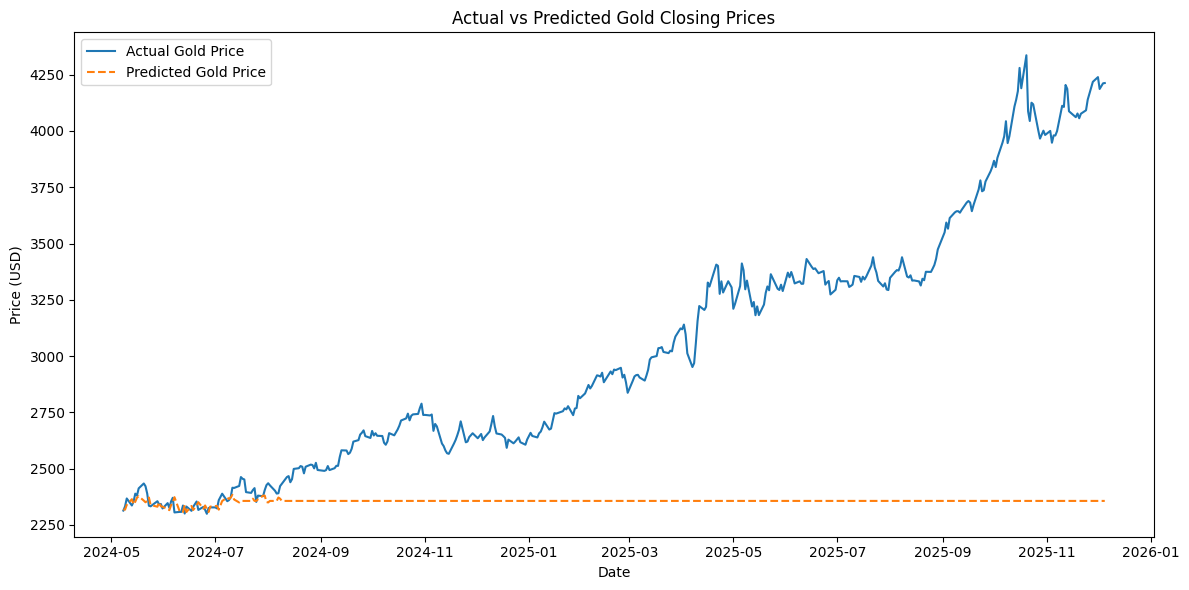

In [8]:
# Dates aligned with the test set
test_dates = data.index[split_index:]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label="Actual Gold Price")
plt.plot(test_dates, y_pred, label="Predicted Gold Price", linestyle="--")
plt.title("Actual vs Predicted Gold Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
last_row = data.iloc[-1]
last_features = last_row[["PreviousDayPrice", "TwoDaysAgoPrice", "ThreeDaysAgoPrice"]].values.reshape(1, -1)

next_day_prediction = model.predict(last_features)[0]
print(f"Predicted next-day closing price for {ticker}: {next_day_prediction:.2f} USD")


Predicted next-day closing price for GC=F: 2356.40 USD
